In [3]:
import os
import os
folder_path = '/content/drive/MyDrive/models'
os.makedirs(folder_path, exist_ok=True)

In [4]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [5]:
def DF(directory):
    paths=pd.Series(sorted(directory.glob(r"*.png")),name="ImagPath").astype(str)
    return paths

Paths=Path("/content/drive/MyDrive/SatImages")
Img=DF(Paths)

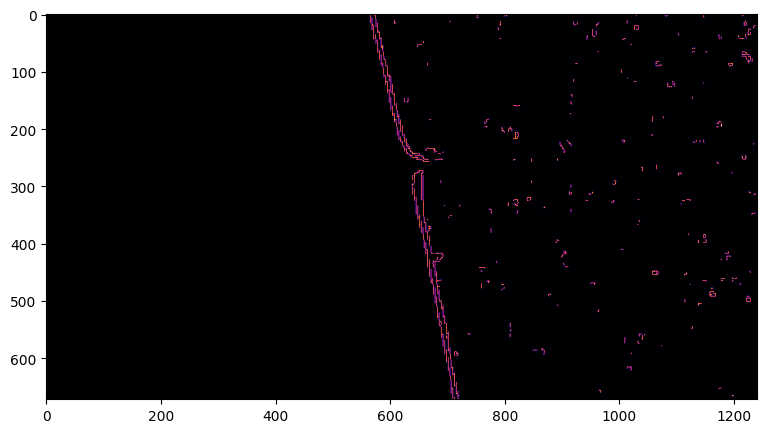

In [6]:
image=cv2.imread(Img[0],cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5, 5), 0)
edge = cv2.Canny(image, threshold1=250, threshold2=200)

plt.figure(figsize=(10,5))
plt.imshow(edge,cmap="inferno")
plt.show()

In [7]:
Edges = np.argwhere(edge== 255) #255 is the threshold, that would specify the algo to select the extreme points only
DataP=np.array(Edges)

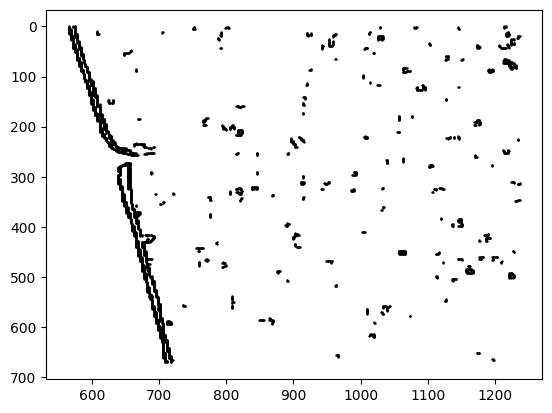

In [8]:
year=1984
df=pd.DataFrame(DataP)
df.columns=["Axis",year]
plt.figure()
plt.scatter(df[year],df["Axis"],s=0.5,color="Black" )
plt.gca().invert_yaxis()
plt.show()

In [9]:
df.to_csv("Test.csv",index=False)

In [10]:
year=1984
df=pd.DataFrame(DataP)
df.columns=["Axis",year]
df= df.drop_duplicates(subset=["Axis"]).reset_index(drop=True)

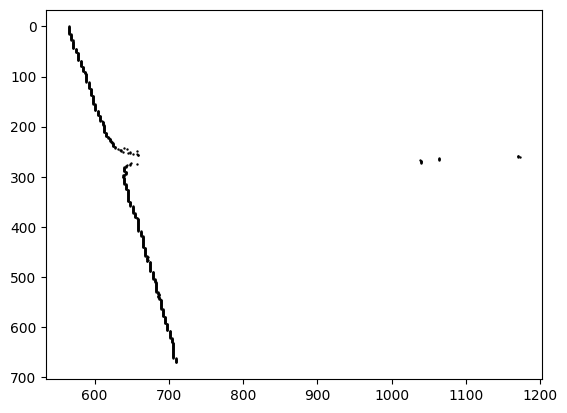

In [11]:
plt.figure()
plt.scatter(df[year],df["Axis"],s=0.5,color="Black" )
plt.gca().invert_yaxis()
plt.show()

In [12]:
df.to_csv("DF.csv",index=False)

In [13]:
for i in range(1,len(Img)):
    image=cv2.imread(Img[i],cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edge = cv2.Canny(image, threshold1=250, threshold2=200)
    edge_points = np.argwhere(edge == 255)
    Data_points=np.array(edge_points)
    ndf=pd.DataFrame(Data_points)
    year=1984+i
    ndf.columns=["Axis",year]
    ndf= ndf.drop_duplicates(subset=["Axis"]).reset_index(drop=True)
    df = pd.concat([df, ndf[year]], axis=1)
    df.to_csv("DF.csv",index=False)

In [14]:
Points=pd.read_csv("DF.csv")

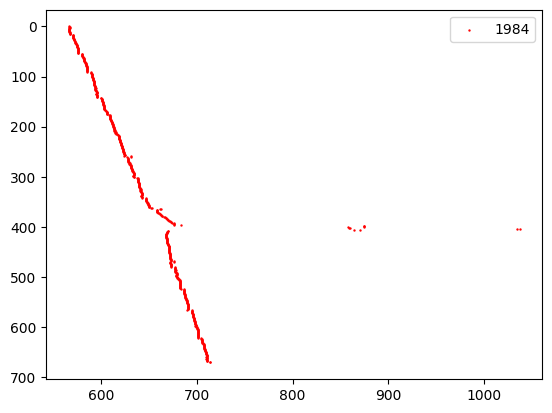

In [15]:
plt.figure()
plt.scatter(Points["2022"],Points["Axis"],s=0.5,color="Red",label="1984")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [16]:
for i in range(1984, 2023):
    c = Points[str(i)]
    c = c.ffill()
    Points[str(i)] = c

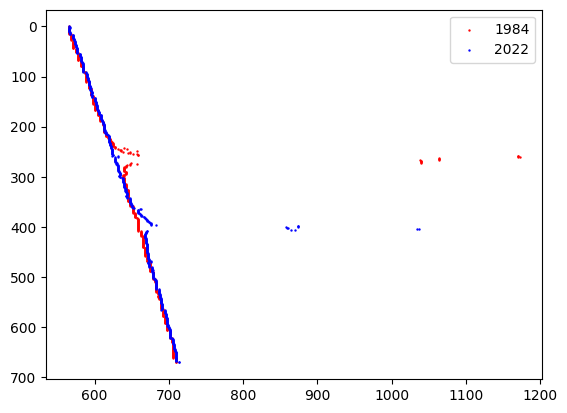

In [17]:
plt.figure()
plt.scatter(Points["1984"],Points["Axis"],s=0.5,color="Red",label="1984")
plt.scatter(Points["2022"],Points["Axis"],s=0.5,color="Blue",label="2022")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

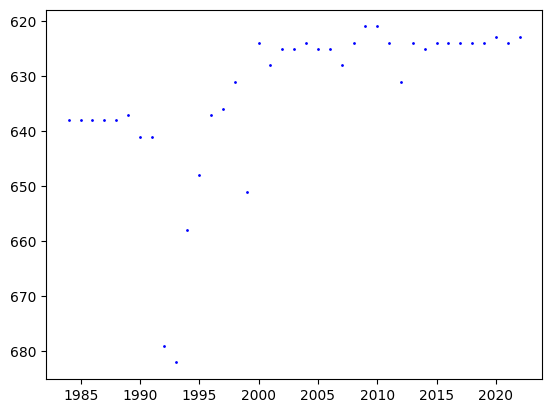

In [18]:
#a plot on how the location of a pixel in one row changes year by year
y = np.array(Points.iloc[250][1:]).reshape(-1, 1)
years = np.array([i for i in range(1984, 2023)]).reshape(-1, 1)

plt.figure()
plt.scatter(years,y,s=1,color="blue" )
plt.gca().invert_yaxis()
plt.show()

In [19]:
from sklearn.svm import SVR
rbf_models = []
C = Points["1984"].mean()

for i in range(len(Points)):
    x = np.array(Points.iloc[i][1:])
    years = np.array([i for i in range(1984, 2023)]).reshape(-1, 1)
    rbf_model = SVR(kernel='rbf', C=C, gamma=0.1)
    rbf_model.fit(years, x.ravel())
    rbf_models.append(rbf_model)

In [20]:
def Prediction_svr(year):
    pred_points = []
    year = np.array([year]).reshape(-1, 1)
    for rbf_model in rbf_models:
        prediction = rbf_model.predict(year)
        pred_points.append(prediction)
    return pred_points

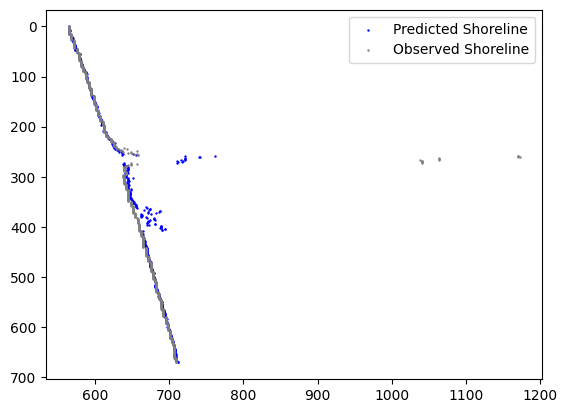

In [21]:
plt.figure()
plt.scatter(Prediction_svr(2040),Points["Axis"],s=0.5,color="Blue",label="Predicted Shoreline")
plt.scatter(Points["1984"],Points["Axis"],s=0.5,color="Grey",label='Observed Shoreline')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
ground_truth = Points["1984"]

predicted_shoreline = np.array(Prediction_svr(1984)).flatten()

mae = mean_absolute_error(ground_truth, predicted_shoreline)
mse = mean_squared_error(ground_truth, predicted_shoreline)
r2 = r2_score(ground_truth, predicted_shoreline)

accuracy_percentage = (1 - mae / ground_truth.mean()) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')
print(f'Accuracy SVR: {accuracy_percentage:.2f}%')

Mean Absolute Error (MAE): 0.1292873181909525
Mean Squared Error (MSE): 0.6823944132908795
R-squared (R2): 0.9998841103895449
Accuracy SVR: 99.98%


In [23]:
import pickle
i=0
for model in rbf_models:
    filename = os.path.join(folder_path, f'svr_point_{i}.pkl')
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    i+=1

print(f"Models saved in: {folder_path}")

Models saved in: /content/drive/MyDrive/models
